In [34]:
from math import log
import operator

def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    #change to discrete values
    return dataSet, labels

def calcShannonEnt(dataSet):#计算香农熵
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the the number of unique elements and their occurance
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2) #log base 2
    return shannonEnt
    
def splitDataSet(dataSet, axis, value): #返回数据集的某一个属性（用axis参数来选定）满足他的取值范围之一的value的所有数据
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:]) #注意attend和expend的区别
            retDataSet.append(reducedFeatVec)
    return retDataSet
    
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)     
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature                      #returns an integer

def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): 
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

def createTree(dataSet,labels): #先选择属性再去掉属性后进行递归求子树，最后拼接。
    classList = [example[-1] for example in dataSet] #先获取当前数据集内的所有属性值
    if classList.count(classList[0]) == len(classList): #全部都属于一个类的时候返回
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet #只有一个属性时返回
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet) #在当前数据集可选的属性中选择最好的划分方式（熵）
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])#去掉当前选择的属性 以便于后期遍历
    featValues = [example[bestFeat] for example in dataSet] #获取各项数据在当前属性的下的值
    uniqueVals = set(featValues) #集合化属性值
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree                            
    
def classify(inputTree,featLabels,testVec):
    #print(featLabels)
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

def storeTree(inputTree,filename):
    import pickle
    fw = open(filename,'w')
    pickle.dump(inputTree,fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename)
    return pickle.load(fr)

In [35]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

#python3不允许myTree.keys()[0] 这种形式出现
#type(myTree.keys()) is dict_keys 需要将它转化为list

def getNumLeafs(myTree):
    numLeafs = 0
    #print(type(myTree.keys()))
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():#注意python类型判断
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]


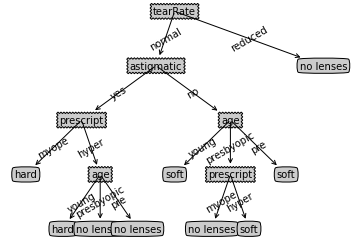

no lenses


In [36]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLables = ['age','prescript','astigmatic','tearRate']
#print(lensesLables)
from copy import deepcopy  #python3 函数作用域问题，如果直接用lenseLables 在createTree后会出现属性缺失的问题
lables = deepcopy(lensesLables) #所以此处用了deepcopy解决这个问题
lensesTree = createTree(lenses,lables)
#print(lensesLables)
createPlot(lensesTree)
test_pairs = ['presbyopic','hyper','no','reduced']
result = classify(lensesTree,lensesLables,test_pairs)
print(result)